<a href="https://colab.research.google.com/github/manumeehl/trajectories/blob/main/Trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
''' SYSTEM PACKAGES '''
!apt install tesseract-ocr
!pip install opencv-python-headless pytesseract pytube

In [2]:
''' PYTHON PACKAGES '''
from google.colab.patches import cv2_imshow as show
from pytesseract import image_to_string as img_to_str
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from pytube import YouTube
import pandas as pd
import numpy as np
import math
import cv2
import re

In [3]:
''' VIDEO UTILITIES '''
def get_video(url, path):
  ''' Download a Video from YouTube and save it as MP4 '''
  vid = YouTube(url)
  print(f"Downloading Video '{vid.streams[0].title}'")
  vid.streams.filter(progressive=True, file_extension='mp4')\
  .order_by('resolution').desc().first()\
  .download(output_path=path, filename='launch.mp4')
  print('Download complete')

def show_frame(vid, position):
  ''' Show a single frame from a video file '''
  # ToDo: Read the video here
  vid.set(cv2.CAP_PROP_POS_FRAMES, int(position))
  ret, frame = vid.read()
  show(frame)

In [4]:
''' TIME CONVERSION TOOLS '''
def clock_to_secs(clockstring):
  ''' Convert a mission clock string to an integer second value '''
  tense = -1 if clockstring[:2] == 't-' else 1
  # Remove the T+- sign
  clockstring = clockstring [2:]
  # Get the seconds
  units = clockstring.split(':')
  hours = int(units[0])
  minutes = int(units[1])
  seconds = int(units[2])

  return tense * (hours * 3600 + minutes * 60 + seconds)

def elapsed_secs(frame1, frame2, fps):
  ''' Get the time between two frames in a video '''
  return round((frame2 - frame1) / fps, 2)

In [5]:
''' OCR PARSING AND DATA EXTRACTION '''
def parse_clock(string):
  ''' Extract mission clock, altitude and velocity from a given string '''
  mission_clock = re.findall(r't[+-]\d{2}:\d{2}:\d{2}', string.lower().replace(' ', ''))
  if mission_clock: return mission_clock[0]
  else: return None

def parse_trajectory(string):
  ''' Extract altitude and velocity from a given string '''
  # Apply a blacklist
  blacklist = ['stage 1', 'stage 2', 'falcon 9', 'starlink']
  for w in blacklist:
    string = string.replace(w, '')
  # Find all numbers and floats in the string
  numbers = re.findall(r'\d+(?:\.\d+)?', string.lower())
  numbers = list(set([float(x) for x in numbers]))
  # Check if there are exactly two numbers
  if len(numbers) == 2:
   return  [min(numbers), max(numbers)]
  else:
    return None

def extract_data(vid):
  ''' Collect all datapoints from a frame '''
  ret, frame = vid.read()
  # Get the regions of interest
  clockframe, stage1, stage2 = get_snippets(frame)
  ocr_config = '--psm 11'
  # Scan for data
  clock = parse_clock(img_to_str(clockframe, config={}))
  trajectory_s1 = parse_trajectory(img_to_str(stage1, config=ocr_config))
  trajectory_s2 = []
  return clock, trajectory_s1, trajectory_s2

In [6]:
''' VIDEO PROCESSING '''
def preprocess(frame):
  ''' Apply preprocessing filters to a frame '''
  return cv2.bitwise_not(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

def get_snippets(frame):
  ''' Cut out regions of interest and apply filters for OCR '''
  height, width, _ = frame.shape

  stage1 = preprocess(frame[height-80:height-40,50:300])
  stage2 = preprocess(frame[height-80:height-40,width-300:width-50])
  clock = preprocess(frame[height-110:height-20,int(width/2-100):int(width/2+100)])

  return clock, stage1, stage2

In [7]:
''' VIDEO PARAMETER SCAN '''
def await_liftoff():
  ''' Identify the frame at which liftoff occurs '''
  # Look for the clock every minute
  framepos, interval = 0, int(30 * fps)
  first_clock = None
  # Await first mission clock appearance
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval
    clock, t1, t2 = extract_data(vid)

    # Wait until the mission clock first appears
    if clock and not first_clock:
      first_clock = clock
      interval = 1

    # Now wait for the next full second
    if first_clock and clock != first_clock:
      framepos -= clock_to_secs(clock) * fps
      return framepos


In [19]:
def detect_meco(velocity: pd.Series, window=5) -> bool:
  vel = velocity.values.tolist()
  # Check if the dataset is long enough:
  if len(vel) < window:
    break
  # Check if the velocity has been declining for x values
  detected_meco = True
  prev_val = vel[len(vel)-1]
  for i in range(5):
    if vel[len(vel)-1-i] < prev_val:
      detected_meco = False
  return detected_meco

In [21]:
''' CONTINUOUS DATA SCAN '''
waypoints = {
    'MECO' : False
}

def process_launch(vid, liftoff_frame, duration):
  framepos = liftoff_frame
  trajectory = pd.DataFrame(columns = ['clock', 'secs', 's1_alt', 's1_vel'])

  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    ret, frame = vid.read()
    clock, trajectory_s1, trajectory_s2 = extract_data(vid)

    if clock and trajectory_s1:
      # Save data
      secs = elapsed_secs(liftoff_frame, framepos, fps)

      # If MECO has not happened, check for MECO
      if not waypoints['MECO']:
        waypoints['MECO'] = detect_meco(trajectory['s1_vel'])
        if waypoints['MECO']:
          show(frame)

      trajectory.loc[len(trajectory)] = [clock, secs] + trajectory_s1
      # Skip to next second
      framepos += int(fps - ((framepos - liftoff_frame) % fps)) + 3
    else:
      framepos += 5
    if framepos > liftoff_frame + (duration*fps):
      break

  return trajectory

In [22]:
''' MAIN ROUTINE '''
# Fetch file from youtube
#url = 'https://www.youtube.com/watch?v=agYuEAkEljw'
#get_video(url, 'launches')

vidpath = 'launches/launch.mp4'
vid = cv2.VideoCapture(vidpath)
fps = vid.get(cv2.CAP_PROP_FPS)

print('Started video processing.')
#print('Awaiting liftoff...')
#liftoff_frame = await_liftoff()

print('Liftoff registered.')
print('Monitoring trajectories...')
trajectory = process_launch(vid, liftoff_frame, 3 * 60)

Started video processing.
Awaiting liftoff...
Liftoff registered.
Monitoring trajectories...


IndexError: ignored

In [11]:
''' DATA POST-PROCESSING '''
def detect_spikes(data, threshold=1.5):
    for i in range(1, len(data)-1):
        mean = (abs(data[i-1]) + abs(data[i+1])) / 2
        if abs(data[i]) / mean > threshold:
            data[i] = -mean if data[i] < 0 else mean
    return data

def interpolate_curve(x, y):
    x = [math.floor(i) for i in x]
    # Double the number of data points
    x_smooth = np.linspace(x[0], x[-1], len(x) * 2)

    # Use cubic spline interpolation to generate smooth y values
    f = interp1d(x, y, kind='quadratic')
    y_smooth = f(x_smooth)

    return x_smooth, y_smooth

trj = trajectory.copy()

trj['s1_alt'] = detect_spikes(trajectory['s1_alt'].values.tolist())
trj['s1_vel'] = detect_spikes(trajectory['s1_vel'].values.tolist())

trj.rename(columns={"s1_alt": "S1 Altitude", 's1_vel': 'S1 Velocity'}, inplace=True)

trj.to_csv('trajectory.csv')

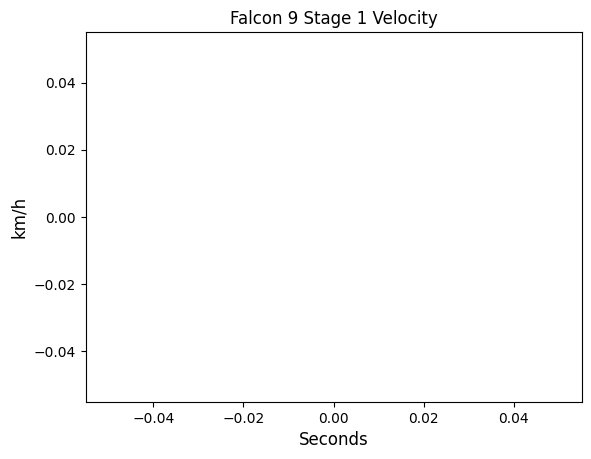

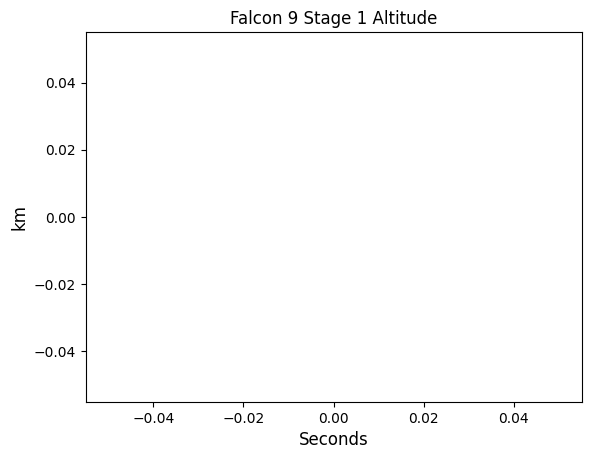

In [12]:
''' DATA PLOTS '''
#trajectory = pd.read_csv('trajectory.csv')
clock = trj['secs'].values.tolist()

altitude = trj['S1 Altitude'].values.tolist()
velocity = trj['S1 Velocity'].values.tolist()

plt.title('Falcon 9 Stage 1 Velocity')
plt.xlabel('Seconds', fontsize=12)
plt.ylabel('km/h', fontsize=12)
plt.plot(clock, velocity)
plt.show()

plt.title('Falcon 9 Stage 1 Altitude')
plt.xlabel('Seconds', fontsize=12)
plt.ylabel('km', fontsize=12)
plt.plot(clock, altitude)
plt.show()